In [17]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature
from skimage import external
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import least_squares
import cv2
import tifffile as tiff
import os
from scipy import signal
import time
from scipy.optimize import minimize
from scipy.stats import norm
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm
import argparse
import ast
from PIL import Image
import re

params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}

folder = 'LASSENA_Calib/'

def getImageDescription(im): return ast.literal_eval(im.tag[270][0])
def getClockScalingFactor(): return (28/1000)/(1750000) 
def get_tiff_integration_time(im): return float(getImageDescription(im)["integration time"])*getClockScalingFactor()


#Going to use this to get rid of dodgy files with 0 integration time
#Courtesy of sam


def get_file_names(folder): #function returns ordered list of numbers of files in folder
    _, _, files = next(os.walk(folder))
    data = []
    #dark = []
    for file in files:
        try: 
            #file.replace(date,'')
            #file.replace(file_info,'')
            #file.replace(filetype,'')
            data.append(folder+'/'+file)
        except: continue
    return data
'''
def sort_folders(folders, batches = [],sorted_folders=[],file_info='pA_2x2cm_col',path='LASSENA_Calib/'):
    for folder in folders:
        folder = str(folder)
        folder = folder.replace(path,'')
        folder = folder.replace(file_info,'')
        folder = folder.replace(folder[folder.find('/'):],'')
        folder = folder.replace('[\'','')
        print(folder)
        batches.append(int(folder))
    batches = sorted(batches)
    batches = [str(batch) for batch in batches]
    sorted_folders = [batch.join(file_info) for batch in batches]
    return sorted_folders
'''      
    

def get_data_loc(folder): #function returns ordered list of numbers of files in folder
    _, folders,_ = next(os.walk(folder))
    fold,dark_fold,IsItOn,Myst = [],[],[],[]
    for subfolder in folders:
        if subfolder.count('dark')==1:
            dark_fold.append(get_file_names(folder+subfolder))
        elif subfolder.count('IsItOn')==1:
            IsItOn.append(get_file_names(folder+subfolder))
        elif subfolder.count('mystery')==1:
            Myst.append(get_file_names(folder+subfolder))
        elif subfolder.startswith('LASSENA_Calib/50pA_2x2cm_col/.DS_Store')==True:
             continue
        else:
            fold.append(get_file_names(folder+subfolder))
        #fold = sort_folders(fold)
    return fold, dark_fold, IsItOn, Myst


def snip(image,chop=2): return np.array([l[chop:-chop-1] for l in image[chop:-chop-1]])
    #This chops L R U D chop number of elements (so Hough works)

def image_ret(file): return Image.open(file)
    #folder = 'LASSENA_Calib/'
    #filetype = '.tiff'
    #would add these commented sections into the imread part
    #inverted_img = np.invert(img)
    #am inverting and changing mm.tiff 
    #had to get rid of the snip bit for the tag to work

def roberts(image):
    Gx = signal.convolve(np.array([[1,0],[0,-1]]),image)
    Gy = signal.convolve(np.array([[0,1],[-1,0]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def line_eqn(line): 
    x0,x1,y0,y1 = line
    m = (y1-y0)/(x1-x0)
    c = y0
    return [m,c]

def find_intercept(line1, line2):
    m1,c1 = line1
    m2,c2 = line2
    x = (c1-c2) / (m2-m1)
    y = m1 * x + c1
    return [x,y]  

def hough_grid(image,base_thresh=0,thresh_step=50,peaks=4,sep=200):
    #am changing thresh_step
    thresh = base_thresh
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    base_image = roberts(image)
    image = np.where(base_image>thresh,1,0)
    #plt.imshow(image,cm.gray)
    h, theta, d = hough_line(image, theta=tested_angles)
    num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    while num_lines != 4:
        print(num_lines)
        if num_lines == 0:
            raise Exception("Could not find 4 lines in image")
        thresh += thresh_step
        image = np.where(base_image>thresh,1,0)
        h, theta, d = hough_line(image, theta=tested_angles)
        num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    plot_hough(h,theta,d)
    #plt.imshow(image, cmap=cm.gray)
    origin = np.array((0, image.shape[1]))
    lines = ([])
    #print(thresh)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=sep,num_peaks=peaks)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        #plt.plot(origin, (y0, y1), '-r')
        lines.append(line_eqn([origin[0],origin[1],y0,y1]))
    #plt.xlim(origin)
    #plt.ylim((image.shape[0],0))
    #plt.title('Detected lines')
    #plt.tight_layout()
    #plt.show()
    print(lines)
    return lines

def cross_points(image,lines):
    #print(image.dtype)
    #print(lines.dtype)
    #takes lines and works out where they cross 
    #returns list of [x1,y1], [x2,y2]... of where points are
    done_list =([])
    pts = ([])
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i!=j and not any(point in done_list for point in [[i, j], [j, i]]):
                done_list.append([i,j])
                p1,p2 = find_intercept(lines[i],lines[j])
                if 0<p1<image.shape[0] and 0<p2<image.shape[1]:
                    pts.append([int(p1),int(p2)])
    sqr = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = np.sum(pts,axis = 1)
    sqr[0] = pts[np.argmin(s)]
    sqr[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    sqr[1] = pts[np.argmin(diff)]
    sqr[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return sqr



def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack individually
    rect = pts
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    #specifying points
    # top-left, top-right, bottom-right, and bottom-left
    sqr = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, sqr)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

def plot_hough(h,theta,d):
    plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray,aspect=1/10)
    plt.title('Hough transform')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.show()
    
def get_images(group): return np.array([np.asarray(image_ret(image)) for image in group])

def sum_pixel(images): return images.sum(axis=0)

def avg_bunch(group): 
    for image in group:
        if get_tiff_integration_time(image_ret(image)) ==0: 
            group.remove(image)
        else: continue
    stripped_images = get_images(group)
    #average of group of images
    #returns single value for bunch
    return stripped_images.mean(axis=0)

data, dark, OnCheck,Myst = get_data_loc(folder)
dark_start = avg_bunch(dark[1])

def dark_remov_avg(group): 
    for image in group:
        if get_tiff_integration_time(image_ret(image)) ==0: 
            group.remove(image)
        else: continue
    stripped_images = get_images(group)
    stripped_images = np.array([im - dark_start for im in stripped_images])
    #average of group of images
    #returns single value for bunch
    return stripped_images.mean(axis=0)
#np.array([image_ret(i) for i in bckr_count]).mean(axis=0)
     
def avg_img(images,img_mean=np.array([])): 
    for image in images:
        if get_tiff_integration_time(image_ret(image)) !=0: 
            np.append(img_mean,np.mean(np.asarray(image_ret(image))))
        else: continue
    #average of each individual image in a bunch
    #returns value for each indivdual image as a list for all the images
    return img_mean


def pixel_val(warped): #takes warped image and 
    in_avg, in_std= np.mean(warped),np.std(warped)/np.sqrt(len(warped))
    return ([in_avg,in_std])

#def file2num(file): return int(file[file.find('/')+1:file.find('p')])



#dark_img_folder = 'Define this folder'
#bckgr_count = get_file_nums(dark_img_folder)
#assumes the filename is the same as for normal files
#dark = avg_pv(bckgr_count)

#print(data[17])


37
19
16
14
14
13
14
14
13
13
14
15
15
12
5


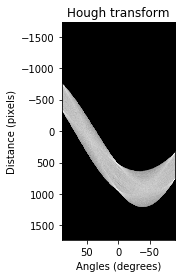

[[-4.7369515717340015e-17, 337.59762800115686], [20.760908494357448, -19221.270900370244], [-9.473903143468003e-17, 738.7136245299394], [25.380927575503588, -13301.070912028077]]


In [18]:
dark_mid = avg_bunch(dark[0])
dark_end = avg_bunch(dark[2])
img_for_roi = dark_start-avg_bunch(data[17])
ROI_pts = cross_points(img_for_roi,hough_grid(img_for_roi))

In [51]:
def get_numbers(data_set,file_info='pA_2x2cm_col',path='LASSENA_Calib/',date='100220',filetype='.tiff'):
    numbers = [0]  
    for data in data_set:
        for file in data:
            file = file.replace(date,'')
            file = file.replace(file_info,'')
            file = file.replace(filetype,'')
            file = file.replace(path,'')
            file = file.replace(file[file.find('/'):],'')
            file = int(file)
            if numbers[-1] != file: numbers.append(file)
    numbers.pop(0)
    return numbers

def get_pv(dataset,ROI_pts):
    data_vals = [dark_remov_avg(group) for group in dataset]
    point_pv = [pixel_val(four_point_transform(image,ROI_pts))[0] for image in data_vals]
    std_dev_pv = [pixel_val(four_point_transform(image,ROI_pts))[1] for image in data_vals]
    return point_pv,std_dev_pv

def sort_order(list_for_order,unordered_list): #takes list to get ordered from order of other list
    now_ordered_list = [x for _,x in sorted(zip(list_for_order,unordered_list))]
    ordered_list_for_order = sorted(list_for_order)
    return now_ordered_list,ordered_list_for_order

files_numbers = get_numbers(data)
warped_files,std_dev = get_pv(data,ROI_pts)
std_dev = sort_order(files_numbers,std_dev)[0]
warped_files,files_numbers = sort_order(files_numbers,warped_files)

Dark image value at mid 3000pA in ROI = 19.434455255543867 +/- 0.4414611879303118
Dark image value at end 10500pA in ROI = 16.181535236603434 +/- 1.1275101313908253


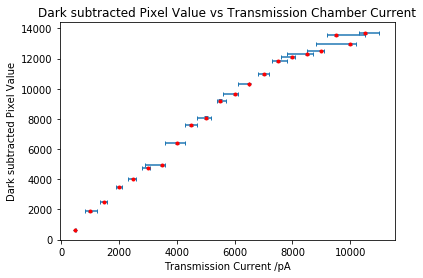

No handles with labels found to put in legend.


12


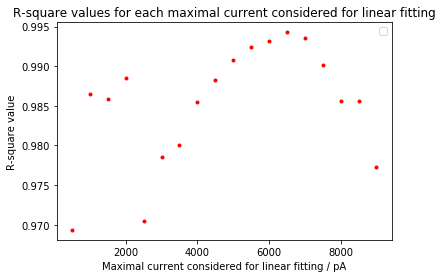

In [69]:
FOLDER = r'Current Error'
COL_NAMES = ['Positive Horiz error', 'Negative Horiz error']
LINES_TO_SKIP = -1


def get_one_pv(data,ROI_pts): return pixel_val(four_point_transform(dark_remov_avg(data),ROI_pts))

myst_warped,myst_std_dev = get_pv(Myst,ROI_pts)
dark_mid,dark_mid_std = get_one_pv(dark[0],ROI_pts)
dark_end,dark_end_std = get_one_pv(dark[2],ROI_pts)
print(r'Dark image value at mid 3000pA in ROI = {} +/- {}'.format(dark_mid,dark_mid_std))
print(r'Dark image value at end 10500pA in ROI = {} +/- {}'.format(dark_end,dark_end_std))
def read_csv_files_in_folder(folder_name):
    folder_name = os.listdir(FOLDER)
    for idx, fn in enumerate(folder_name): #puts data in 3d stepping through file
        try:
            file_path = (FOLDER + os.sep + fn)
            a = np.genfromtxt(file_path, dtype = int,delimiter=',', skip_header=1)#finds the commas and skips title row
            if idx == 0:
                data = np.empty([a.shape[0],a.shape[1], len(folder_name)])
            data[:,:, idx] = a
        except: continue
    return data

a = read_csv_files_in_folder(FOLDER)

ptiv_error,ntiv_error = [*zip(*a[:,0])][0],[*zip(*a[:,1])][0]
 
plt.title('Dark subtracted Pixel Value vs Transmission Chamber Current')
plt.xlabel('Transmission Current /pA')
plt.ylabel('Dark subtracted Pixel Value')

plt.errorbar(x=files_numbers,y=warped_files,yerr=std_dev,xerr = np.array([ntiv_error,ptiv_error]),ls='None',capsize=2,barsabove=True)
plt.plot(files_numbers,warped_files,'r.')
def poly(x,a,b,c): return a*x**2+b*x+c
popt, pcov = scipy.optimize.curve_fit(poly,files_numbers,warped_files,p0=[1,1,0],sigma=std_dev)
perr = np.sqrt(np.diag(pcov))
#slope, intercept, r_value, p_value, std_err = stats.linregress(files_numbers,warped_files)

def try_different_fits(files_numbers,warped_files):
    R_sqr = []
    file_lim = []
    for j in range(len(files_numbers)-3):
        j = j+3
        slope, intercept, r_value, p_value, std_err = stats.linregress(files_numbers[:j],warped_files[:j])
        R_sqr.append(r_value**2)
        file_lim.append(files_numbers[j-3])
    return R_sqr,file_lim

plt.show()



R_sqr_vals, file_max = try_different_fits(files_numbers,warped_files)
plt.plot(file_max,R_sqr_vals,'r.')
plt.title('R-square values for each maximal current considered for linear fitting')
plt.xlabel('Maximal current considered for linear fitting / pA')
plt.ylabel('R-square value')
print(np.argmax(R_sqr_vals))
plt.legend()
#fname='R-square_vs_Max_Current'
#plt.savefig(fname, dpi=300, quality=95, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,metadata=None)
plt.show()
#plt.plot(files_numbers,[slope*i+intercept for i in files_numbers],label='Linear Fit {:.3f}x+{:.3f} and R-sqr={:.3f}'.format(slope,intercept,r_value**2))                                                              
#plt.plot(files_numbers,[poly(i,*popt) for i in files_numbers],label=r'Fit equation = $ax^2+bx+c$')
#from pynverse import inversefunc
#Current = inversefunc(poly, args=(popt[0],popt[1],popt[2]),y_values=myst_warped)
#Current_ptiv = inversefunc(poly, args=(popt[0],popt[1],popt[2]),y_values=(myst_warped[0]+myst_std_dev[0]))
#Current_ntiv = inversefunc(poly, args=(popt[0],popt[1],popt[2]),y_values=(myst_warped[0]-myst_std_dev[0]))
#Current = inversefunc(lambda x: slope*x+intercept,y_values=myst_warped)
#Current_ptiv = inversefunc(lambda x: slope*x+intercept,y_values=(myst_warped[0]+myst_std_dev[0]))
#Current_ntiv = inversefunc(lambda x: slope*x+intercept,y_values=(myst_warped[0]-myst_std_dev[0]))
#plt.plot(Current,myst_warped,'gx',ms=10,label='Mystery Current Value: {:.3f} +{:.3f}or-{:.3f}pA'.format(Current[0],Current_ptiv-Current[0],Current[0]-Current_ntiv))
#plt.axvline(Current_ptiv,label='Mystery current upper bound')
#plt.axvline(Current_ntiv,label='Mystery current lower bound')
#print('Mystery Current = {} +{}or-{}pA'.format(Current,Current_ptiv-Current,Current-Current_ntiv))






Get dark subtract
    Dark_img = average bunch of dark images
Each image - Dark_img
Find Roi
    Put into Hough with largest dataset
Average images in bunch
Need to remove dark from every image and then average them 

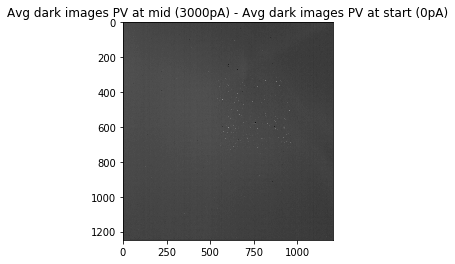

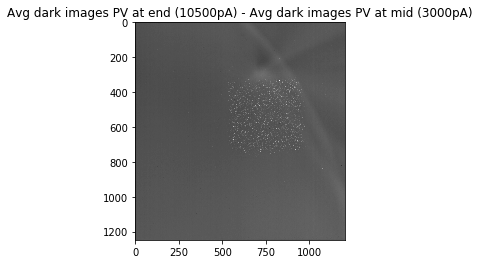

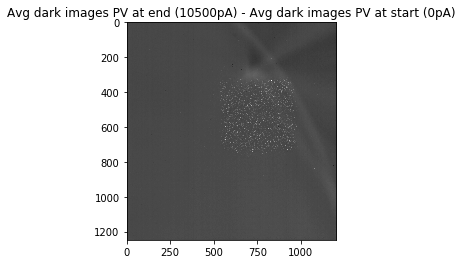

Avg dark 0pA PV 1901.779824678445
Avg dark 3000pA PV 1915.6341789939177
Avg dark 10500pA PV 1904.7259260711285


In [315]:
plt.imshow(avg_bunch(dark[0])-avg_bunch(dark[1]),cm.gray)
plt.title('Avg dark images PV at mid (3000pA) - Avg dark images PV at start (0pA)')
plt.show()
plt.imshow(avg_bunch(dark[2])-avg_bunch(dark[0]),cm.gray)
plt.title('Avg dark images PV at end (10500pA) - Avg dark images PV at mid (3000pA)')
plt.show()
plt.imshow(avg_bunch(dark[2])-avg_bunch(dark[1]),cm.gray)
plt.title('Avg dark images PV at end (10500pA) - Avg dark images PV at start (0pA)')
plt.show()
print('Avg dark 0pA PV {}'.format(np.mean(avg_bunch(dark[1]))))
print('Avg dark 3000pA PV {}'.format(np.mean(avg_bunch(dark[0]))))
print('Avg dark 10500pA PV {}'.format(np.mean(avg_bunch(dark[2]))))